# Projet 2 - Préparez des données pour un organisme de santé publique

In [1]:
import os
import glob
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Only keep the following columns :
# 7: product_name
# 53: nutrition_grade_fr
# 63: energy_100g
# 65: fat_100g
# 66: saturated-fat_100g
# 101: carbohydrates_100g
# 102: sugars_100g
# 112: proteins_100g

cols_used = [7, 53, 63, 65, 66, 101, 102, 112]

chunk_size = 20000
batch_no = 1

dtype_cols = {
    7: str,  
    53: str,
    63: float,
    65: float,
    66: float,
    101: float,
    102: float,
    112: float,
}

# if there are files in the chunks folder, delete them
files = glob.glob('data/chunks/*')
for f in files:
    os.remove(f)

# split the csv file into chunks and save them in the chunks folder for later use
for chunk in pd.read_csv('data/fr.openfoodfacts.org.products.csv', sep='\t', chunksize=chunk_size, dtype=dtype_cols, usecols=cols_used):
    chunk.to_csv(f'data/chunks/fr.openfoodfacts.org.products_{batch_no:03d}.csv', index=False)
    batch_no += 1

In [2]:
# read the main csv file for processing
df = pd.read_csv('data/fr.openfoodfacts.org.products.csv', sep='\t', dtype=dtype_cols, usecols=cols_used)

# Faire des analyses de distribution sur les colonnes

Pour comprendre le jeu de données, je procède ici à l'affichage indépendant de chacun des colonnes sous la forme d'un diagramme à moustache.

Faisons une première analyse des données avec describe

In [3]:
df.describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g
count,2.611130e+05,243891.000000,229554.000000,243588.000000,244971.000000,259922.000000
mean,1.141915e+03,12.730379,5.129932,32.073981,16.003484,7.075940
std,6.447154e+03,17.578747,8.014238,29.731719,22.327284,8.409054
min,0.000000e+00,0.000000,0.000000,0.000000,-17.860000,-800.000000
25%,3.770000e+02,0.000000,0.000000,6.000000,1.300000,0.700000
50%,1.100000e+03,5.000000,1.790000,20.600000,5.710000,4.760000
75%,1.674000e+03,20.000000,7.140000,58.330000,24.000000,10.000000
max,3.251373e+06,714.290000,550.000000,2916.670000,3520.000000,430.000000


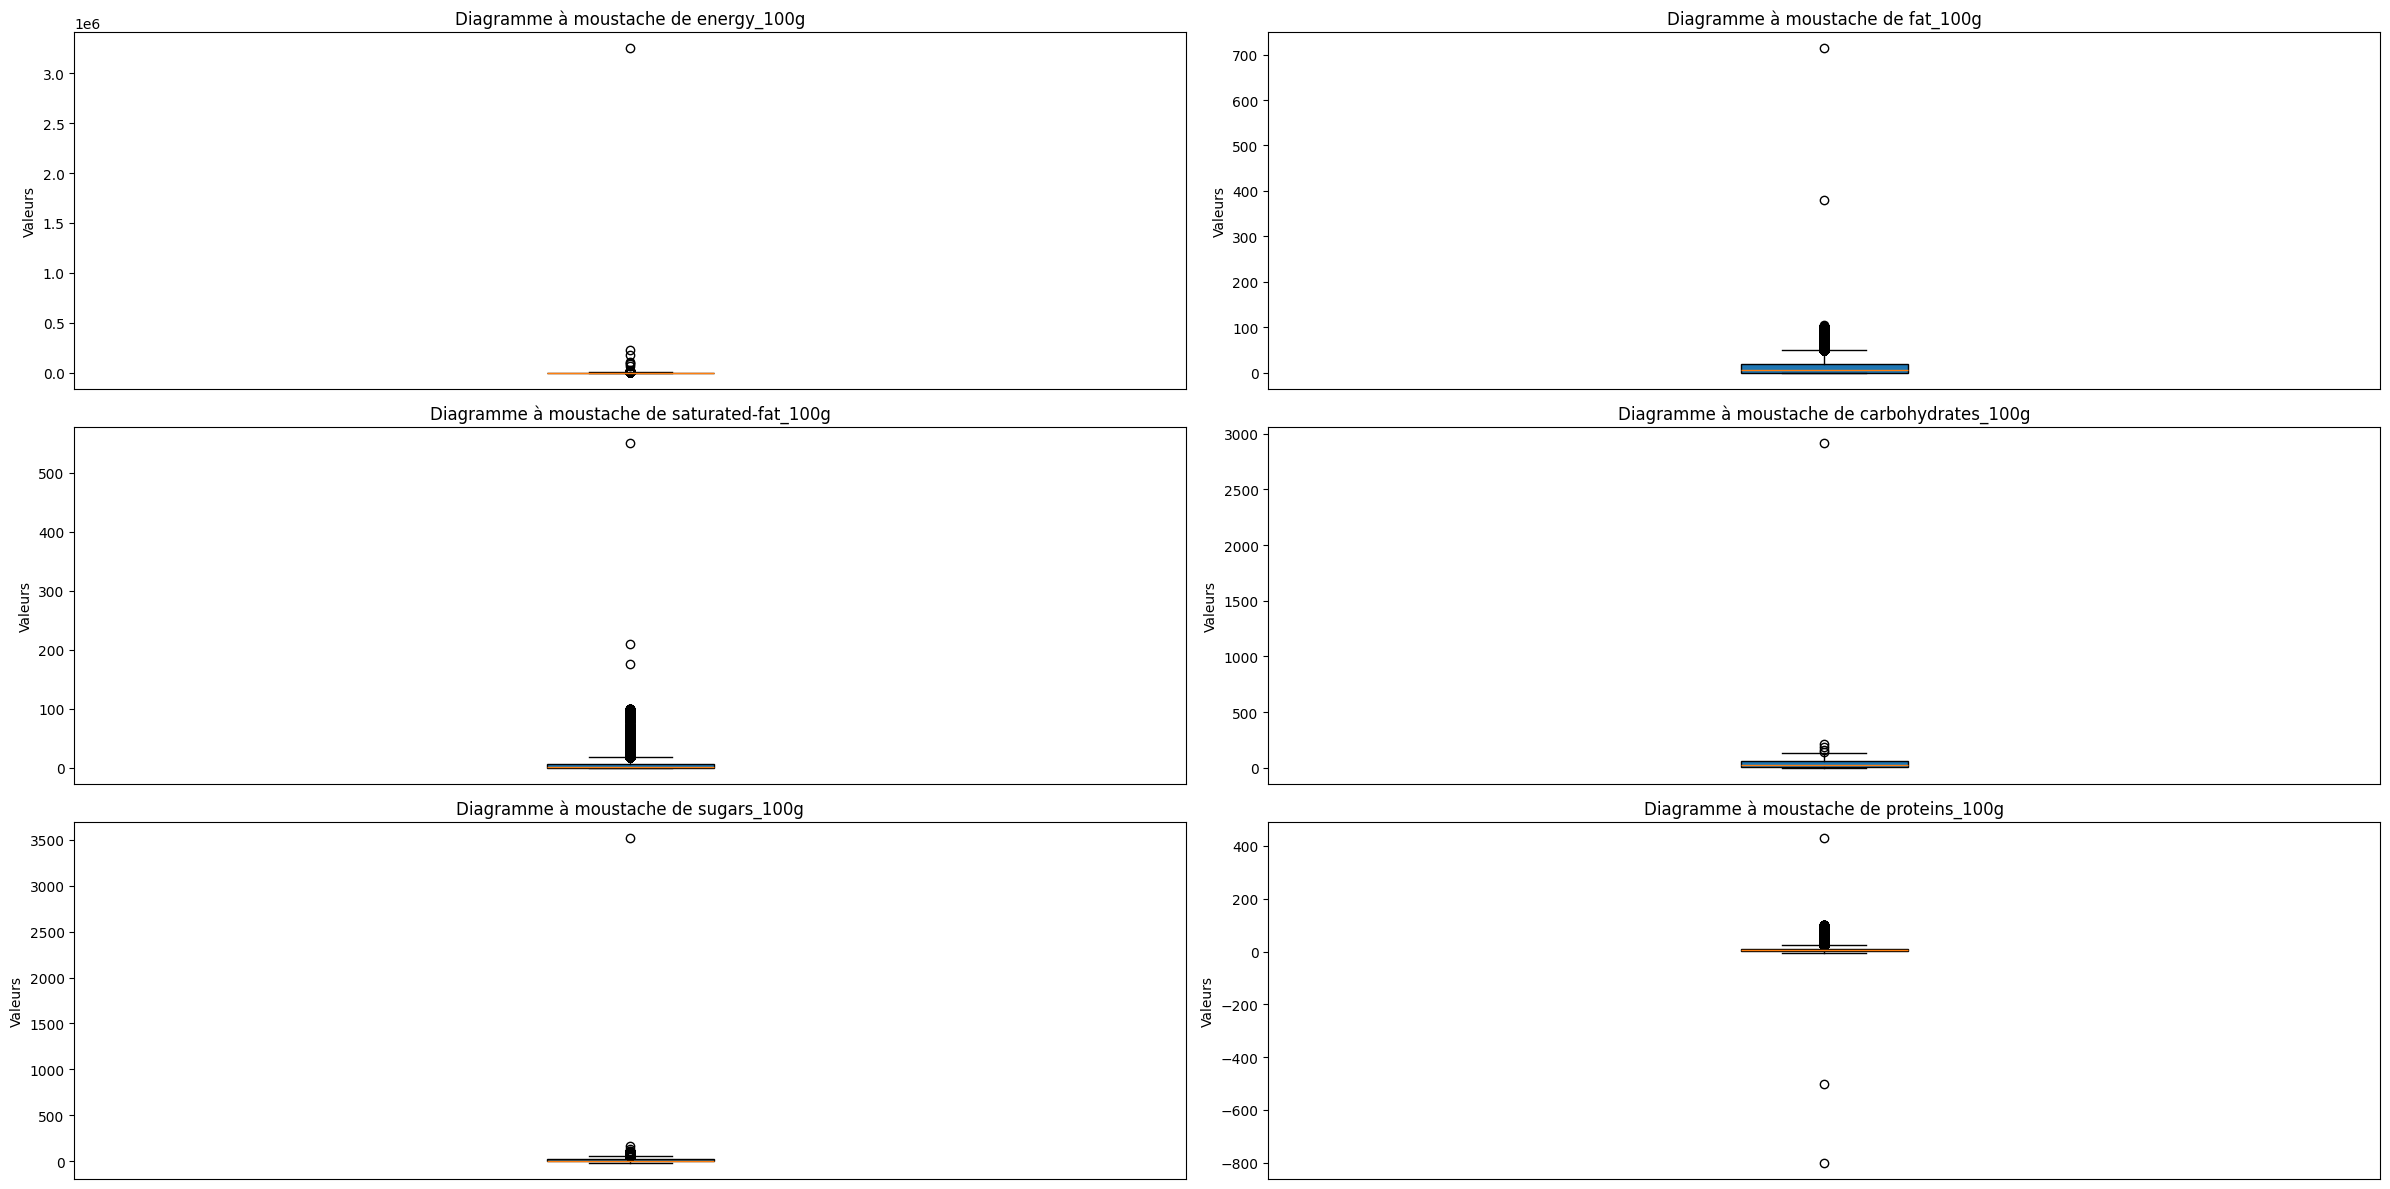

In [4]:
import matplotlib.pyplot as plt
import math

# Données pour le graphique
columns_to_plot = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g']
data_to_plot = [df[col].dropna() for col in columns_to_plot]

# Calculer le nombre de lignes nécessaires
num_rows = math.ceil(len(columns_to_plot) / 2)

# Ajuster la taille de la figure
fig, axs = plt.subplots(num_rows, 2, figsize=(12*2, 4*num_rows))
axs = axs.ravel()

for idx, col in enumerate(columns_to_plot):
    axs[idx].boxplot(data_to_plot[idx], vert=True, patch_artist=True)
    axs[idx].set_title(f'Diagramme à moustache de {col}')
    axs[idx].set_ylabel('Valeurs')
    axs[idx].set_xticks([])

# Supprimer les axes non utilisés s'il y en a
for idx in range(len(columns_to_plot), num_rows*2):
    axs[idx].axis('off')

plt.tight_layout()
plt.show()


## On constate que la plupart des colonnes contiennent des données aberrantes. Enlevons les pour améliorer les résultats de nos analyses par la suite.

Pour cela utilisons la méthode des quartiles et éliminons les valeurs qui ne sont pas dans le range

TODO: expliquer pourquoi je fais cette méthode (éviter les valeurs extrêmes)

TODO: expliquer pourquoi on enlève les valeurs extrêmes ou pas, expliquer pourquoi on enlève les valeurs extrêmes

In [5]:
cols_to_filter = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g']

Q1 = df[cols_to_filter].quantile(0.1)
Q3 = df[cols_to_filter].quantile(0.9)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for col in cols_to_filter:
    condition_without_nan = df[col].isna() | ((df[col] >= lower_bound[col]) & (df[col] <= upper_bound[col]))
    df = df[condition_without_nan]




On réaffiche les diagrammes à moustache.

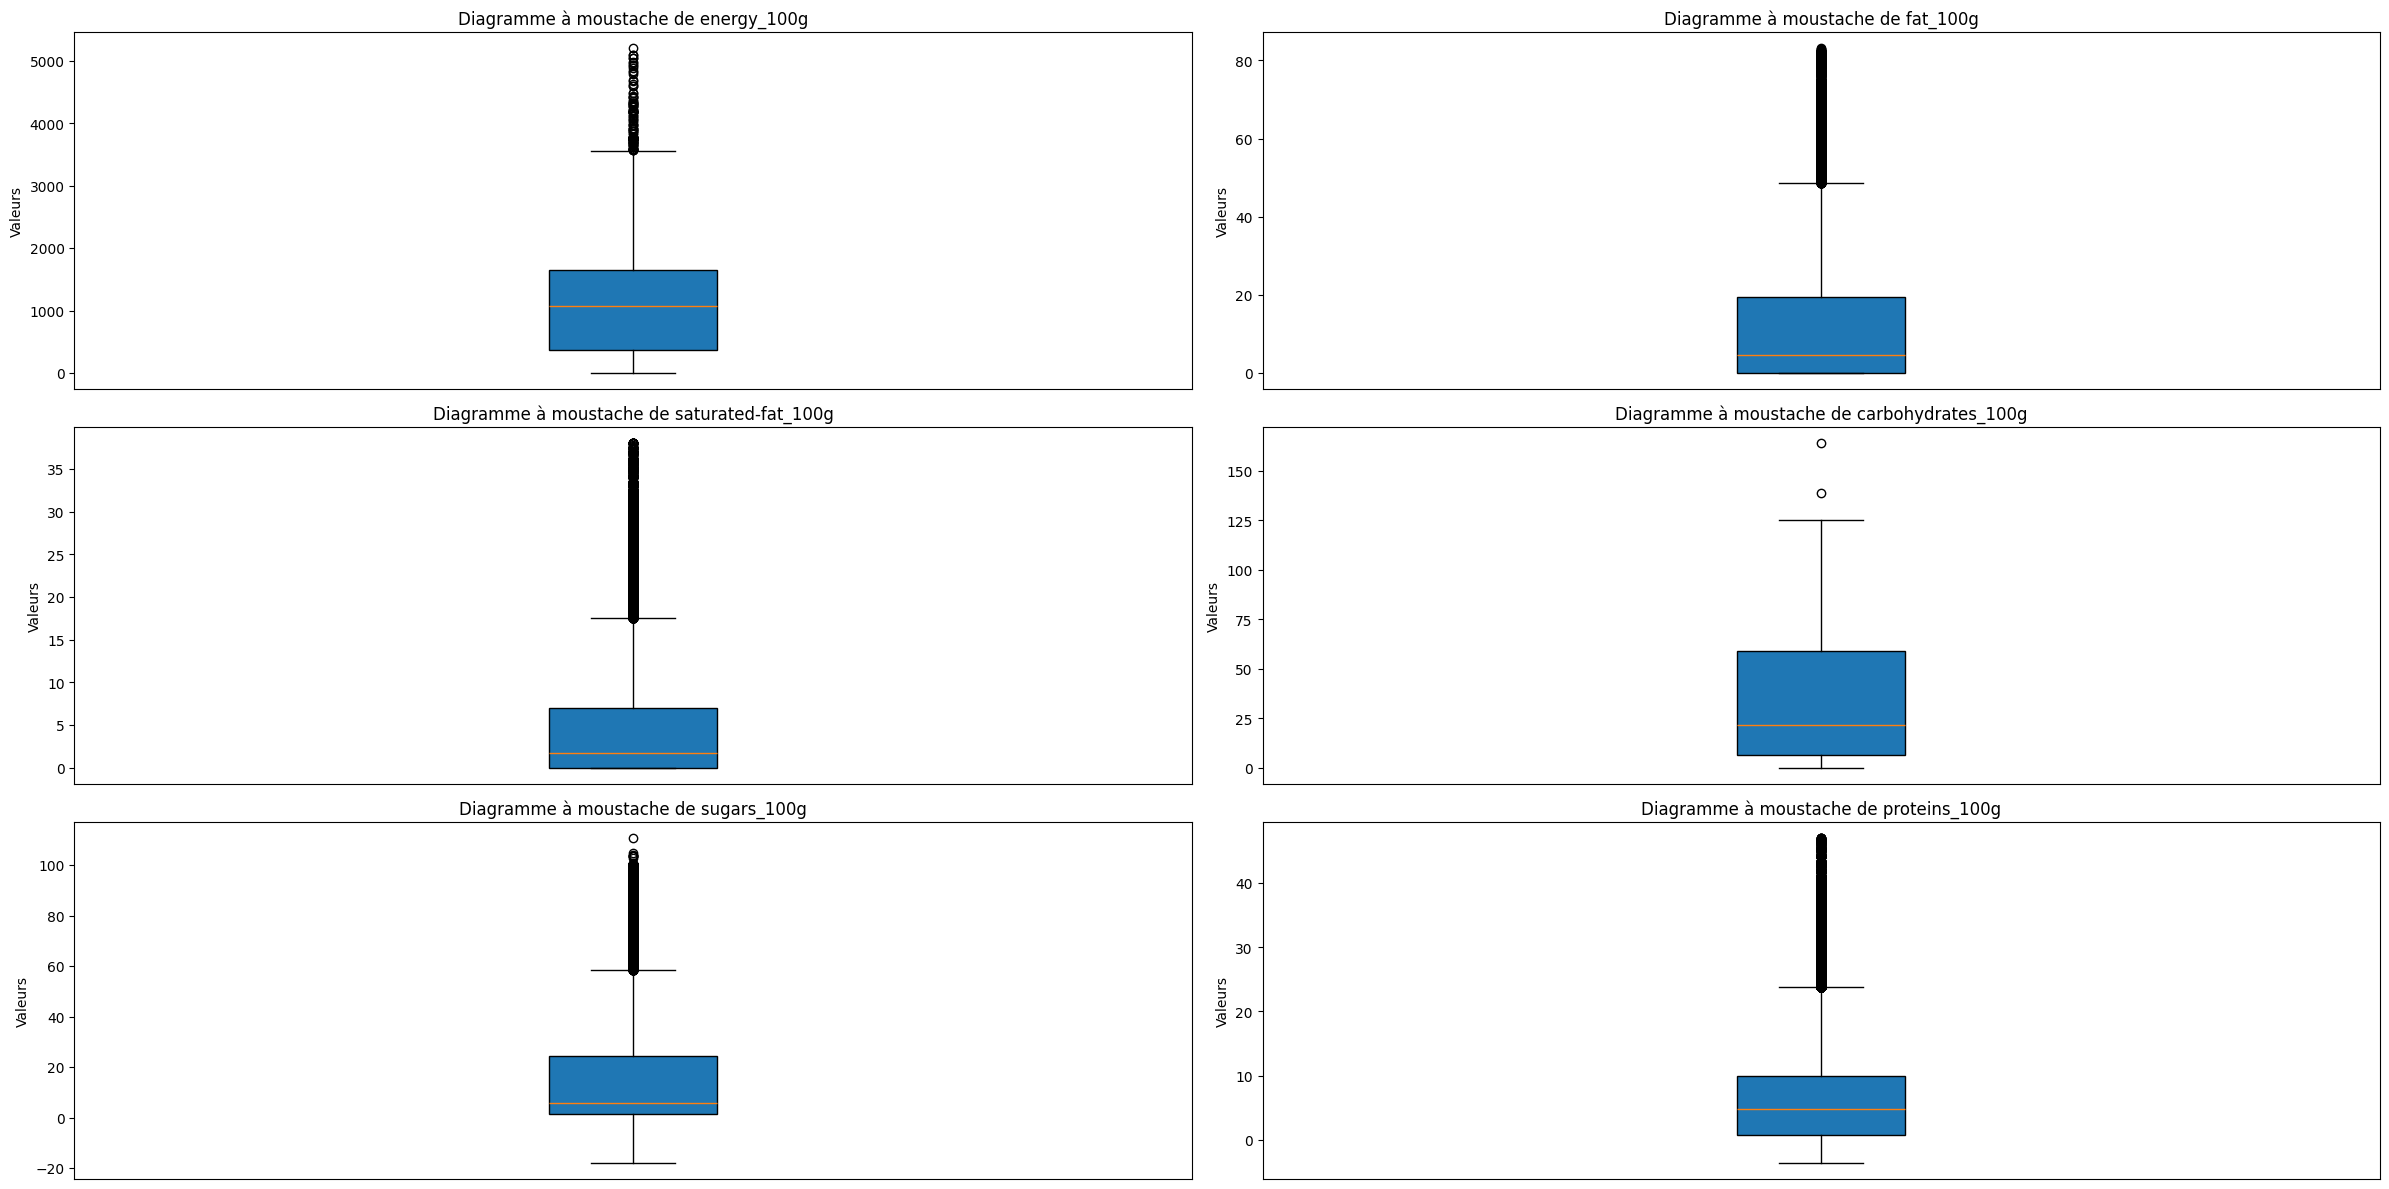

In [6]:
import matplotlib.pyplot as plt
import math

# Données pour le graphique
columns_to_plot = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g']
data_to_plot = [df[col].dropna() for col in columns_to_plot]

# Calculer le nombre de lignes nécessaires
num_rows = math.ceil(len(columns_to_plot) / 2)

# Ajuster la taille de la figure
fig, axs = plt.subplots(num_rows, 2, figsize=(12*2, 4*num_rows))
axs = axs.ravel()

for idx, col in enumerate(columns_to_plot):
    axs[idx].boxplot(data_to_plot[idx], vert=True, patch_artist=True)
    axs[idx].set_title(f'Diagramme à moustache de {col}')
    axs[idx].set_ylabel('Valeurs')
    axs[idx].set_xticks([])

# Supprimer les axes non utilisés s'il y en a
for idx in range(len(columns_to_plot), num_rows*2):
    axs[idx].axis('off')

plt.tight_layout()
plt.show()


## Nous constatons que les valeurs aberrantes de chaque colonne ont étés éliminées. Traitons maintenant les valeurs manquantes

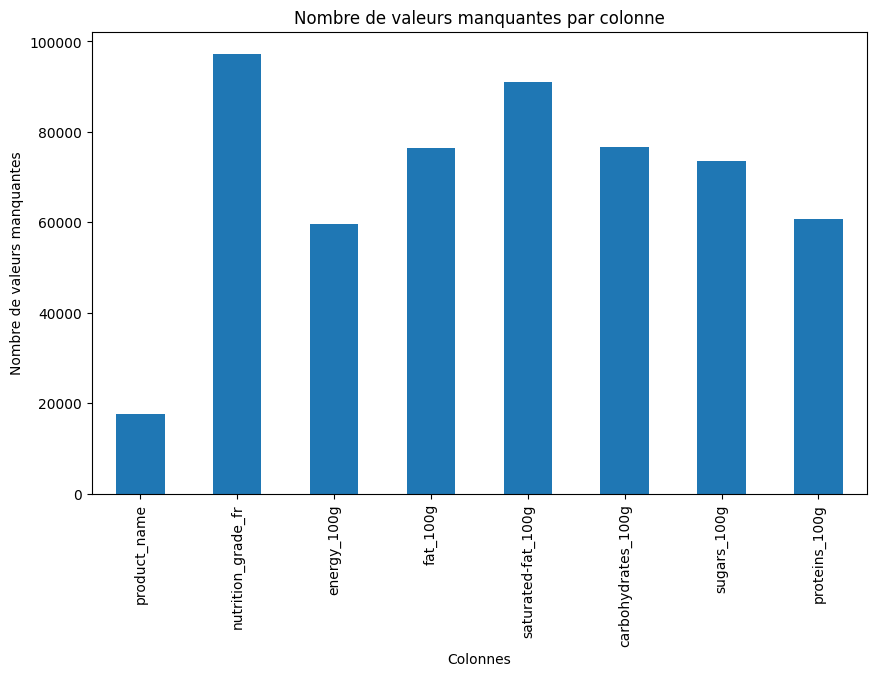

In [7]:
import matplotlib.pyplot as plt

# Compter les valeurs manquantes pour chaque colonne
missing_values = df.isna().sum()

# Afficher graphiquement
plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar')
plt.title('Nombre de valeurs manquantes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Nombre de valeurs manquantes')
plt.show()

## Méthode 1 de traitement des valeurs manquantes : Suppression des N/A
Cette méthode consiste à enlever les observations qui contiennent des valeurs nulles ou manquantes pour la colonne donnée.
Ici la colonne ciblée est "nutrition_grade_fr", qui est la principale colonne de notre jeu de données, et pour laquelle des valeurs manquantes est trop gênant.

In [8]:
# Enlever les valeurs nulles ou manquantes pour la colonne nutrition_grade_fr
df = df.dropna(subset=['nutrition_grade_fr'])

# # Enlever les valeurs nulles ou manquantes pour la colonne carbohydrates_100g
# df = df.dropna(subset=['carbohydrates_100g'])

# # Enlever les valeurs nulles ou manquantes pour la colonne sugars_100g
# df = df.dropna(subset=['sugars_100g'])

# # Enlever les valeurs nulles ou manquantes pour la colonne proteins_100g
# df = df.dropna(subset=['proteins_100g'])

# # Enlever les valeurs nulles ou manquantes pour la colonne nutrition-score-fr_100g
# df = df.dropna(subset=['nutrition-score-fr_100g'])

# # Enlever les valeurs nulles ou manquantes pour la colonne energy_100g
# df = df.dropna(subset=['energy_100g'])

# # Enlever les valeurs nulles ou manquantes pour la colonne fat_100g
# df = df.dropna(subset=['fat_100g'])

# # Enlever les valeurs nulles ou manquantes pour la colonne saturated-fat_100g
# df = df.dropna(subset=['saturated-fat_100g'])

## Méthode 2 de traitement des valeurs manquantes : Utilisation de la valeur médiane
Cette méthode consiste à remplacer la valeur de la colonne ciblée des observations qui contiennent des valeurs nulles ou manquantes pour cette colonne par la valeur médiane de cette colonne. Ici la médiane est utilisée car elle est moins sensible aux valeurs abérrantes (outliers)

Ici la colonne ciblée est "sugars_100g".

In [9]:
df['sugars_100g'].fillna(df['sugars_100g'].median(), inplace=True)

## Méthode 3 de traitement des valeurs manquantes : Utilisation de la bibliothèque sklearn.impute pour une imputation k des plus proches voisins (KNN)
Cette méthode consiste à utiliser l'algorithme des k-plus proches voisins (KNN) pour estimer et remplacer les valeurs manquantes. KNN prend en compte les k observations les plus proches d'une observation avec une valeur manquante pour imputer une valeur. La proximité est souvent mesurée à l'aide d'une métrique de distance, telle que la distance euclidienne.

Dans cette approche, plutôt que de remplacer la valeur manquante par une valeur unique (comme la moyenne ou la médiane), l'algorithme utilise plusieurs observations les plus proches pour estimer une valeur manquante.

Ici la colonne ciblée est "fat_100g".

In [10]:
import numpy as np
from sklearn.impute import KNNImputer

# On ne prend en compte que les valeurs manquantes
mask = df['fat_100g'].isna()

# On applique le KNNImputer à ces valeurs manquantes
imputer = KNNImputer(n_neighbors=5)
df.loc[mask, 'fat_100g'] = imputer.fit_transform(df[['fat_100g']])[mask]


### Utilisation de la méthode d'imputation KNN à la colonne carbohydrates_100g

In [11]:
# On ne prend en compte que les valeurs manquantes
mask = df['carbohydrates_100g'].isna()

# On applique le KNNImputer à ces valeurs manquantes
imputer = KNNImputer(n_neighbors=5)
df.loc[mask, 'carbohydrates_100g'] = imputer.fit_transform(df[['carbohydrates_100g']])[mask]

In [12]:
df.describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g
count,218273.000000,218464.000000,218273.000000,218464.000000,218464.000000,218273.000000
mean,1156.648039,12.676477,4.644530,33.527305,15.128408,7.699472
std,738.061265,13.910251,6.402913,27.159570,19.859605,7.605184
min,0.000000,0.000000,0.000000,0.000000,-17.860000,-3.570000
25%,448.000000,1.100000,0.000000,8.240000,1.400000,2.000000
50%,1174.000000,8.960000,1.760000,30.000000,5.130000,5.710000
75%,1690.000000,20.000000,7.000000,57.140000,23.330000,10.710000
max,5205.000000,83.100000,38.000000,139.000000,104.000000,47.000000


### On enlève les quelques données manquantes des colonnes proteins_100g et saturated-fat_100g

In [13]:
# Enlever les valeurs nulles ou manquantes pour la colonne proteins_100g
df = df.dropna(subset=['proteins_100g'])

# Enlever les valeurs nulles ou manquantes pour la colonne saturated-fat_100g
df = df.dropna(subset=['saturated-fat_100g'])

In [14]:
df.describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g
count,218273.000000,218273.000000,218273.000000,218273.000000,218273.000000,218273.000000
mean,1156.648039,12.676477,4.644530,33.527305,15.137157,7.699472
std,738.061265,13.916336,6.402913,27.171451,19.866088,7.605184
min,0.000000,0.000000,0.000000,0.000000,-17.860000,-3.570000
25%,448.000000,1.100000,0.000000,8.240000,1.400000,2.000000
50%,1174.000000,8.930000,1.760000,30.000000,5.130000,5.710000
75%,1690.000000,20.000000,7.000000,57.140000,23.330000,10.710000
max,5205.000000,83.100000,38.000000,139.000000,104.000000,47.000000


On réaffiche les diagrammes à moustaches pour vérifier que nos modifications n'ont pas introduit de données aberrantes.

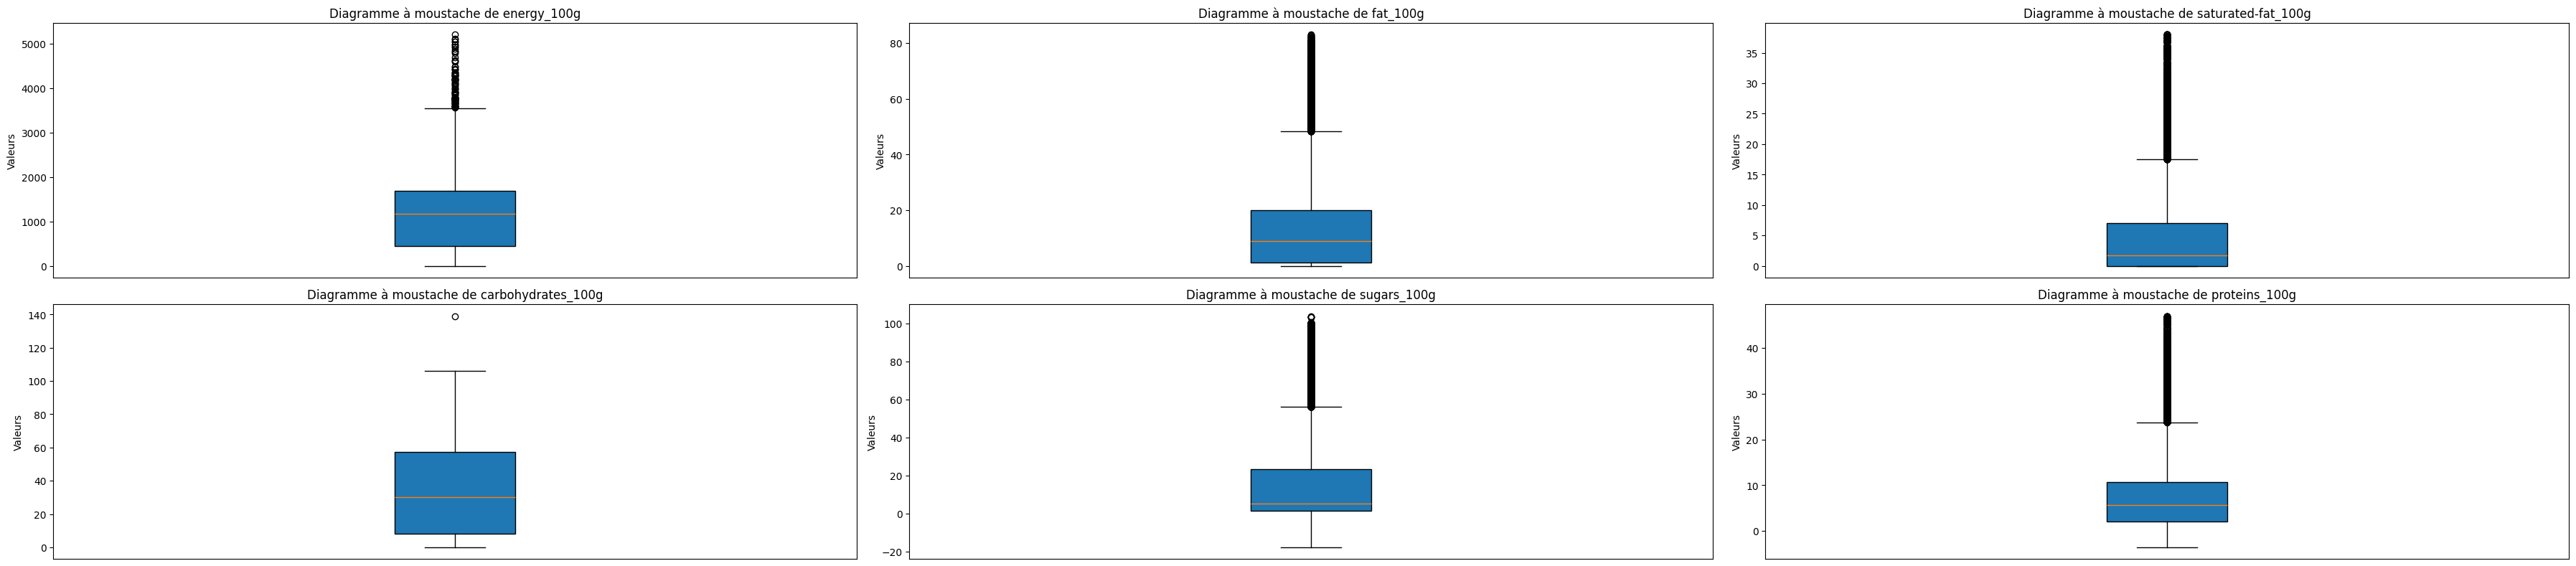

In [15]:
import matplotlib.pyplot as plt
import math

# Données pour le graphique
columns_to_plot = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g']
data_to_plot = [df[col].dropna() for col in columns_to_plot]

# Calculer le nombre de lignes nécessaires
num_rows = math.ceil(len(columns_to_plot) / 3)

# Ajuster la taille de la figure
fig, axs = plt.subplots(num_rows, 3, figsize=(12*3, 4*num_rows))
axs = axs.ravel()

for idx, col in enumerate(columns_to_plot):
    axs[idx].boxplot(data_to_plot[idx], vert=True, patch_artist=True)
    axs[idx].set_title(f'Diagramme à moustache de {col}')
    axs[idx].set_ylabel('Valeurs')
    axs[idx].set_xticks([])

# Supprimer les axes non utilisés s'il y en a
for idx in range(len(columns_to_plot), num_rows*3):
    axs[idx].axis('off')

plt.tight_layout()
plt.show()

### On constate que maintenant toutes les colonnes sont remplies et utilisables pour les analyses.

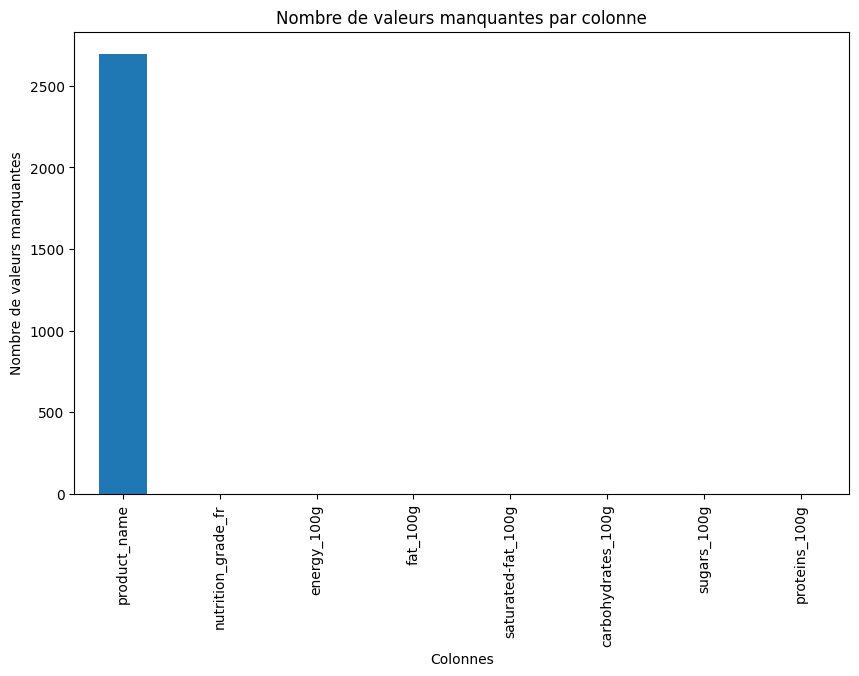

In [16]:
import matplotlib.pyplot as plt

# Compter les valeurs manquantes pour chaque colonne
missing_values = df.isna().sum()

# Afficher graphiquement
plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar')
plt.title('Nombre de valeurs manquantes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Nombre de valeurs manquantes')
plt.show()

### La colonne 'product_name' ne participera pas aux analyses donc nous pouvons y admettre des valeurs manquantes.

In [17]:
df.sample(20)

,product_name,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g
46619,Lasagna Macaroni Product,a,1494.0,1.790000,0.000,73.210000,3.57,12.50
98592,Apple Cinnamon Fruit & Grain Bars,c,1582.0,6.760000,1.350,72.970000,32.43,5.41
225201,Maïs pop-corn,a,1666.5,4.200000,0.670,75.900000,0.00,12.00
106515,Chop Grilling Seasons,d,837.0,0.000000,0.000,40.000000,0.00,0.00
311081,Alubias a la jardinera,c,355.0,1.900000,0.300,10.300000,0.50,4.80
287506,hohes C Multi-Vitamin,b,198.0,0.500000,0.100,10.000000,9.90,0.70
32371,Light & Fit Greek Crunch - S'mores,d,386.0,1.770000,0.709,11.300000,7.80,7.80
45129,Loaded Potato Skins Stuffed With Cheddar Chees...,d,1289.0,15.380000,7.690,27.470000,1.10,12.09
248532,Sauce Hannibal,d,1276.0,27.600000,2.100,11.600000,7.60,0.80
30759,Italian Dressing,d,1117.0,23.330000,3.330,13.330000,13.33,0.00


In [18]:
df.shape

(218273, 8)

Après nettoyage des données aberrantes, et remplissage des données manquantes selon 3 méthodes différentes, nous obtenons un ensemble de 182315 observations et 8 variables. Nous pouvons maintenant commencer les analyses.

# Analyse univariée des colonnes

cf boites à moustache

### nutrition_grade_fr

In [19]:

df['nutrition_grade_fr'].value_counts()

nutrition_grade_fr
d    61882
c    45313
e    41549
a    35512
b    34017
Name: count, dtype: int64

<Axes: xlabel='nutrition_grade_fr'>

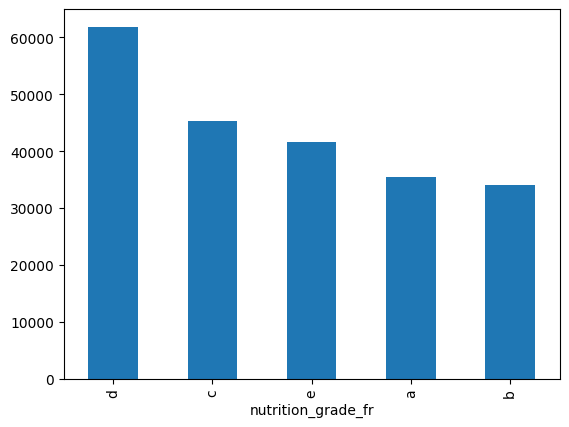

In [20]:
df['nutrition_grade_fr'].value_counts().plot.bar()

# Analyse multivariée : nuage de points

In [21]:
# Transform nutrition_grade_fr column to numeric
df['nutrition_grade_fr'] = df['nutrition_grade_fr'].map({'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5})

# drop the product_name column because it's useless for the model
df_without_name = df.drop(columns=['product_name'])





In [22]:
# correlation matrix
corr = df_without_name.corr()
corr

,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g
nutrition_grade_fr,1.000000,0.576666,0.530505,0.626522,0.232593,0.444747,0.105728
energy_100g,0.576666,1.000000,0.727439,0.560611,0.564567,0.363420,0.320125
fat_100g,0.530505,0.727439,1.000000,0.679273,-0.020383,0.016738,0.330771
saturated-fat_100g,0.626522,0.560611,0.679273,1.000000,0.008139,0.160510,0.258629
carbohydrates_100g,0.232593,0.564567,-0.020383,0.008139,1.000000,0.611576,-0.131719
sugars_100g,0.444747,0.363420,0.016738,0.160510,0.611576,1.000000,-0.282163
proteins_100g,0.105728,0.320125,0.330771,0.258629,-0.131719,-0.282163,1.000000


<Axes: >

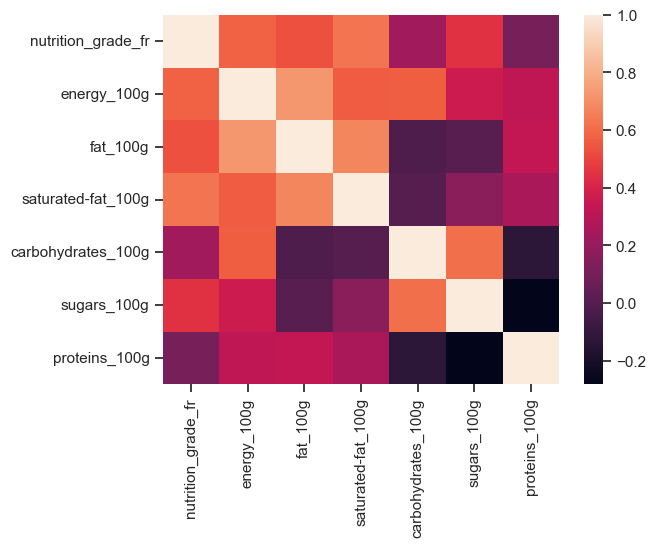

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks", color_codes=True)

cmap = sns.diverging_palette(220, 10, as_cmap=True)


# heatmap
plt.figure()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)




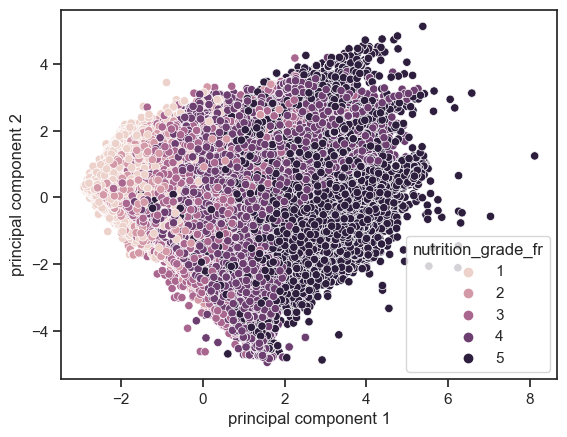

In [24]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Normalisation des données
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_without_name)

# Application de PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Création d'un DataFrame pour le résultat de PCA
pca_df = pd.DataFrame(data = pca_result, columns = ['principal component 1', 'principal component 2'])

# Ajout de la colonne 'nutrition_grade_fr' au DataFrame PCA
pca_df['nutrition_grade_fr'] = df_without_name['nutrition_grade_fr'].reset_index(drop=True)

# Visualisation
plt.figure()
sns.scatterplot(x='principal component 1', y='principal component 2', hue='nutrition_grade_fr', data=pca_df)
plt.show()


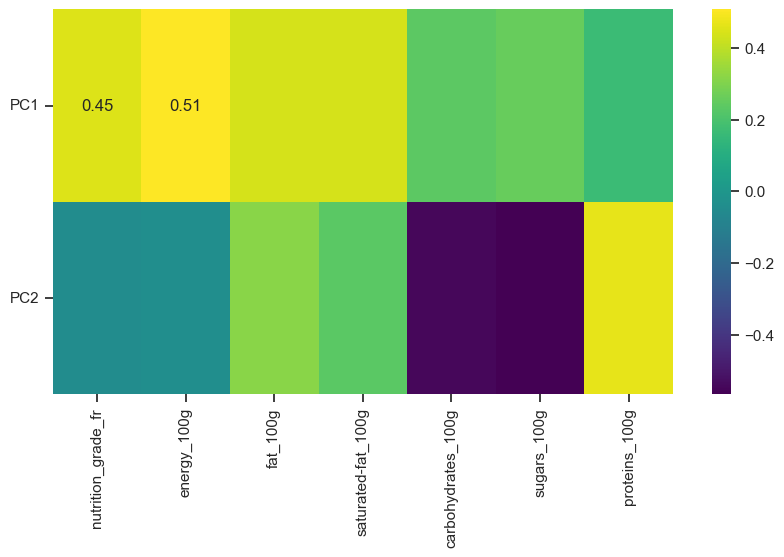

In [25]:
components = pca.components_

components_df = pd.DataFrame(components, columns=df_without_name.columns, index=['PC1', 'PC2'])

import seaborn as sns

plt.figure(figsize=(10, 5))
sns.heatmap(components_df, annot=True, cmap='viridis', cbar=True)
plt.yticks(rotation=0)
plt.show()


TODO: Méthode (graphe) du coude pour la PCA voir le cours

TODO: chercher "eboulis des valeurs propres" ou "cascade des valeurs propres"

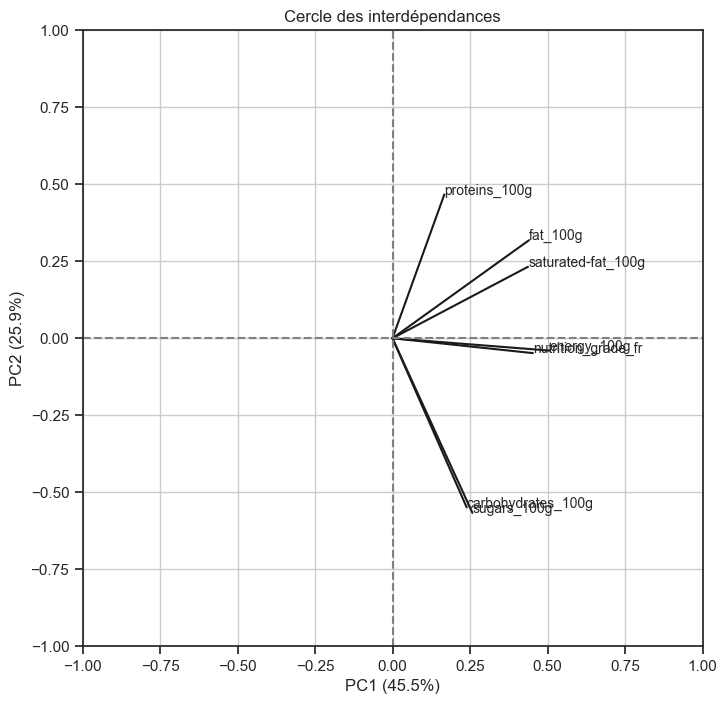

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# 1. Normalisation des données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_without_name)

# 2. ACP
pca = PCA()
pca_result = pca.fit(scaled_data)

# 3. Visualisation
plt.figure(figsize=(8, 8))
for i, (x, y) in enumerate(zip(pca.components_[0], pca.components_[1])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (label) de la variable
    plt.text(x, y, df_without_name.columns[i], fontsize='smaller')
    
# Définir les limites du graphique et les titres des axes
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axvline(0, color='grey', linestyle='--')
plt.axhline(0, color='grey', linestyle='--')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Cercle des interdépendances")
plt.grid(True)

plt.show()


# Commentaire du cercle de corrélations

Ce cercle des corrélations montre plusieurs choses :
- Les éléments qui sont plus ou moins alignés les uns avec les autres sont corrélés entre eux :
    - fat et saturated_fat
    - energy et nutrition_grade_fr
    - sugars et carbohydrates
- Les éléments perpendiculaires entre eux ne sont pas corrélés du tout :
    - fat et sugars par exemple
- Les éléments qui sont dans deux sens opposés sont inversement corrélés :
    - même si ils ne sont pas exactement opposés, on peut voir que proteins et sugars sont inversement corrélés, ainsi généralement un aliment plus sucré et moins protéiné et inversement.

Commenter le cercle des correlations

On pourra voir ensemble la semaine pro les tests stats

Analyses bivariees

- PCA
- Quanti - Quanti
- Qunati - Quali
- Quali - Quali

Quanti = quantitative
Quali = qualitative

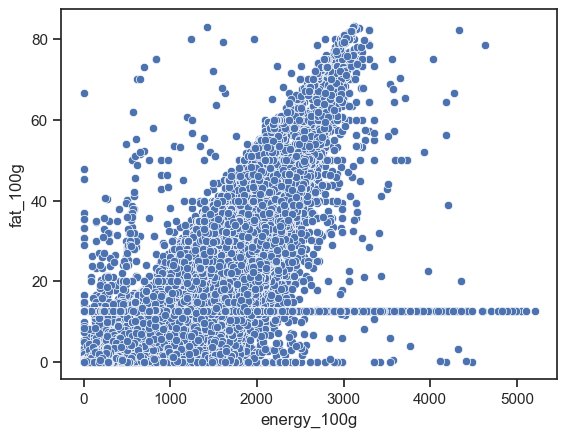

In [27]:
# Quanti - Quanti
# columns_to_plot = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g']
x = 'energy_100g'
y = 'fat_100g'

# scatterplot of bivaried analysis between x and y
plt.figure()
sns.scatterplot(x=x, y=y, data=df_without_name)
plt.show()

Test de pearson (TODO: inclure la formule et décrire si c'est significatif ou pas)

In [28]:
# test statistique pearson

from scipy.stats import pearsonr

# calculate Pearson's correlation
corr, _ = pearsonr(df_without_name[x], df_without_name[y])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.727


Le test de Pearson ou coefficient de corrélation de Pearson, est une statistique qui mesure la force et la direction de la relation linéaire entre deux variables quantitatives. 

**Formule mathématique:**

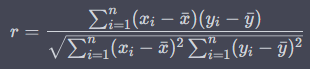

Où \(r\) est le coefficient de corrélation de Pearson, \(n\) est le nombre d'observations, \(x_i\) et \(y_i\) sont les valeurs individuelles des variables \(x\) et \(y\), et \(\bar{x}\) et \(\bar{y}\) sont les moyennes de \(x\) et \(y\), respectivement.

# Application du test de Pearson aux variables fat_100g et nutrition_grade_fr

In [31]:
# Importation des bibliothèques nécessaires
import pandas as pd
import scipy.stats as stats

# Convertir la variable qualitative 'nutrition_grade_fr' en numérique pour effectuer le test de Pearson
df_without_name['nutrition_grade_fr_numeric'] = df_without_name['nutrition_grade_fr'].astype('category').cat.codes

# Effectuer le test de Pearson avec la méthode pearsonr de scipy.stats
r, p_value = stats.pearsonr(df_without_name['fat_100g'], df_without_name['nutrition_grade_fr_numeric'])

# Afficher les résultats
print(f"Coefficient de Pearson: {r}")
print(f"Valeur P: {p_value}")


Coefficient de Pearson: 0.5305045683160189
Valeur P: 0.0


TODO : mettre le graphe qualitatif/quantitatif

#### Le coefficient de Pearson montre une correlation positive entre ces variables, cependant modérée (car 0.5 est assez faible dans les limites de -1 à 1)

Chercher pour la semaine prochaine :

- Quanti Quali : Test Anova (bivarié)
- Quali Quali : ajouter additifs (additifs moyens, etc) ou le "taux de graisse" (créer la colonne qui va interpréter la valeur)
faire un histogramme avec beans = 3 
voir si kmeans donne les mêmes buckets

# Test Anova entre Qualitatif (nutrition_grade_fr) et Quantitatif (fat_100g)

F-value: 23081.75546609921
P-value: 0.0
Rejet de l'hypothèse nulle : Les moyennes sont différentes


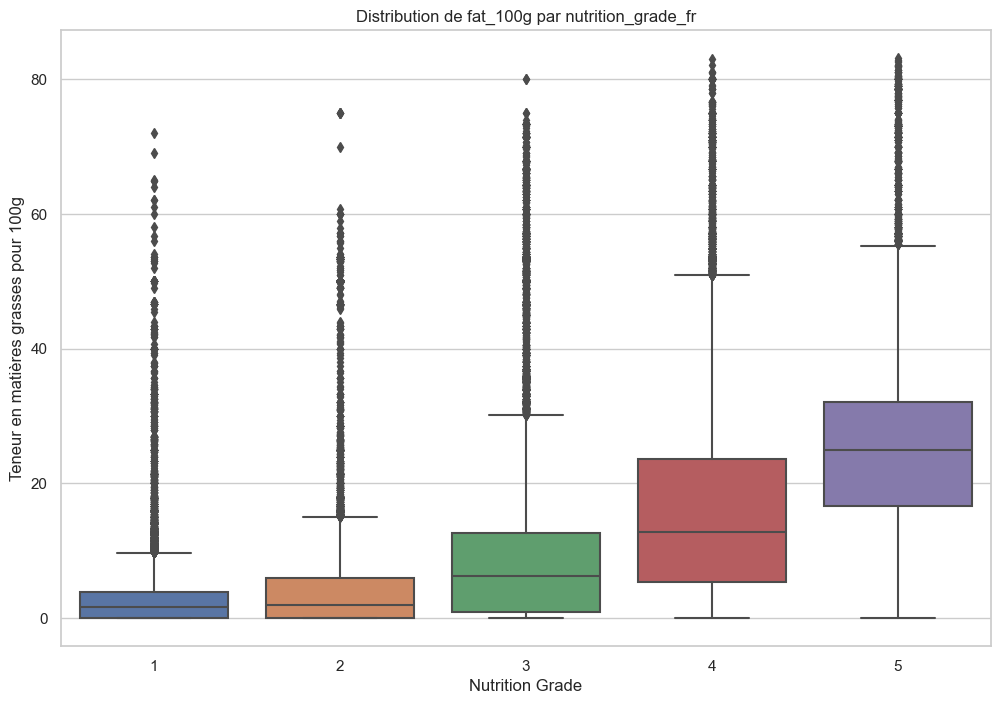

In [29]:
# Importation des bibliothèques nécessaires
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Assumons que df_without_name est votre DataFrame

# Effectuer un test ANOVA à un facteur avec la méthode f_oneway de scipy.stats
fvalue, pvalue = stats.f_oneway(*(df_without_name['fat_100g'][df_without_name['nutrition_grade_fr'] == grade] for grade in df_without_name['nutrition_grade_fr'].unique()))

# Afficher les résultats du test ANOVA
print(f"F-value: {fvalue}")
print(f"P-value: {pvalue}")

# Vérifier si la p-value est inférieure à 0.05
if pvalue < 0.05:
    print("Rejet de l'hypothèse nulle : Les moyennes sont différentes")
else:
    print("On ne peut pas rejeter l'hypothèse nulle : Les moyennes sont similaires")

# Création du graphique avec Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

sns.boxplot(x='nutrition_grade_fr', y='fat_100g', data=df_without_name)

plt.title('Distribution de fat_100g par nutrition_grade_fr')
plt.xlabel('Nutrition Grade')
plt.ylabel('Teneur en matières grasses pour 100g')

# Afficher le graphique
plt.show()


# Test Anova entre Qualitatif (nutrition_grade_fr) et Quantitatif (sugars_100g)

F-value: 14281.768828487393
P-value: 0.0
Rejet de l'hypothèse nulle : Les moyennes sont différentes


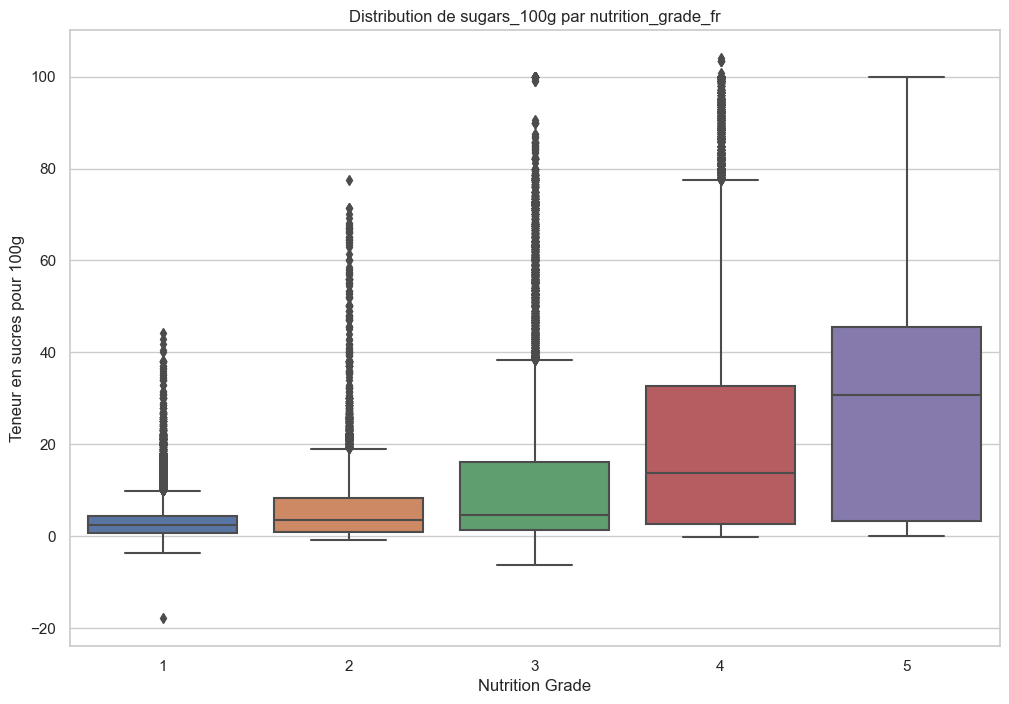

In [30]:
# Importation des bibliothèques nécessaires
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Assumons que df_without_name est votre DataFrame

# Effectuer un test ANOVA à un facteur avec la méthode f_oneway de scipy.stats
fvalue, pvalue = stats.f_oneway(*(df_without_name['sugars_100g'][df_without_name['nutrition_grade_fr'] == grade] for grade in df_without_name['nutrition_grade_fr'].unique()))

# Afficher les résultats du test ANOVA
print(f"F-value: {fvalue}")
print(f"P-value: {pvalue}")

# Vérifier si la p-value est inférieure à 0.05
if pvalue < 0.05:
    print("Rejet de l'hypothèse nulle : Les moyennes sont différentes")
else:
    print("On ne peut pas rejeter l'hypothèse nulle : Les moyennes sont similaires")

# Création du graphique avec Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

sns.boxplot(x='nutrition_grade_fr', y='sugars_100g', data=df_without_name)

plt.title('Distribution de sugars_100g par nutrition_grade_fr')
plt.xlabel('Nutrition Grade')
plt.ylabel('Teneur en sucres pour 100g')

# Afficher le graphique
plt.show()

### Dans les deux cas, l'hypothèse nulle a été rejetée, ce qui signifie que "nutrition_grade_fr" a un impact significatif sur les niveaux de "fat_100g" et "sugars_100g".

On peut aussi observer cette corrélation dans les diagrammes à moustache

Faire le quali-Quali

Expliquer PCA

Conclure

Bonus : machine learning modèle (clusters idée)

Faire des slides : Google Sheets